## Automatic differentiation method

In [1]:
import numpy as np
from ad import grad
from typing import Callable

In [2]:
def objective_function(X: np.ndarray):
    """
    The objective function.
    X: the input, which is a array.
    """
    temp = 0
    shape = X.shape[0]

    for i in range(shape)[0::2]:
        temp += 100 * (X[i+1] - X[i]) ** 2 + (X[i] - 1) ** 2

    return temp

def create_init_x(n):
    """
    Used to create init_x
    n: init_x's length
    """
    result = np.full(n, 1.0)
    result[::2] = -1.2

    return result

In [3]:
def damping_step_generator(lr: float = 0.01, is_constant: bool = True):
    """
    Attention: this is a function generator for generating a damping_step function!
    This is done to make it easy to adjust the learning rate outside of the call.
    """
    def f(x, obj_function, n_iter, lr=lr, is_constant=is_constant):
        if is_constant:
            return lr
        else:
            return lr/np.sqrt(1+n_iter)
    return f

def gradient_descent(initial_x: np.ndarray, max_iters: int, obj_function: Callable, optim_function: Callable, is_log: bool = True):
    """Gradient descent algorithm.
    initial_x: The initial value of the iteration.
    max_iters: Maximum number of iterations.
    obj_function: The objective function.
    optim_function: The optimization function.
    is_log: Used to log the gradient descent procedure. 
    """
    # Define parameters to store x and objective func. values
    xs = [initial_x]
    objectives = []
    x = initial_x
    grad_function = grad(obj_function)
    for n_iter in range(max_iters):
        # compute objective, gradient
        grads = grad_function(x)
        obj = obj_function(x)
        learning_rate = optim_function(x, obj_function, n_iter)
        # update x by a gradient descent step
        x = x - np.dot(learning_rate, grads)
        # store x and objective function value
        xs.append(x)
        objectives.append(obj)
        if is_log:
            if (n_iter+1) % 100 == 0 or n_iter == 0:
                print(f"Gradient Descent({n_iter+1}/{max_iters}): objective={obj}")

    return objectives, xs

In [4]:
init_x = create_init_x(100)
objectives, xs = gradient_descent(init_x, 1000, objective_function, damping_step_generator(lr=0.004))

Gradient Descent(1/1000): objective=24442.000000000004
Gradient Descent(100/1000): objective=27.20844666264489
Gradient Descent(200/1000): objective=12.230479969088421
Gradient Descent(300/1000): objective=5.497728044859017
Gradient Descent(400/1000): objective=2.4712859782789183
Gradient Descent(500/1000): objective=1.1108687691725585
Gradient Descent(600/1000): objective=0.4993470740211037
Gradient Descent(700/1000): objective=0.22446170713680794
Gradient Descent(800/1000): objective=0.10089787362735197
Gradient Descent(900/1000): objective=0.045354644372888026
Gradient Descent(1000/1000): objective=0.020387384711282455


## Visulization

In [5]:
import re
import matplotlib.pyplot as plt
import time
from memory_profiler import memory_usage
from functools import partial
from gc import collect

%load_ext memory_profiler

In [17]:
max_iters = 1000
n = 100
init_x = create_init_x(n)
X_best = np.full(n, 1.0)
y_best = objective_function(X_best)
wrapped_fun = partial(gradient_descent, init_x, max_iters, objective_function, damping_step_generator(lr=0.004), is_log=False)

In [18]:
%%capture time_output

%time memory_cost, (objectives, xs) = memory_usage(wrapped_fun, retval=True)

In [8]:
pattern = re.compile(r'CPU times: total: (\d+\.\d+) s')
match = pattern.search(time_output.stdout)
time_cost = float(match.group(1))

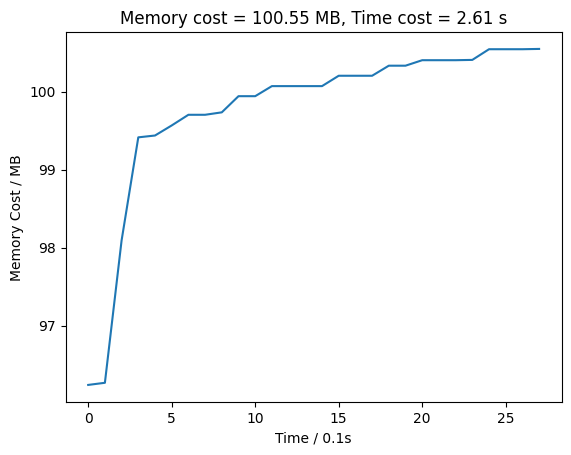

In [9]:
plt.plot(memory_cost)
plt.xlabel('Time / 0.1s')
plt.ylabel('Memory Cost / MB')
plt.title(f"Memory cost = {max(memory_cost):.5} MB, Time cost = {time_cost} s")
plt.show()

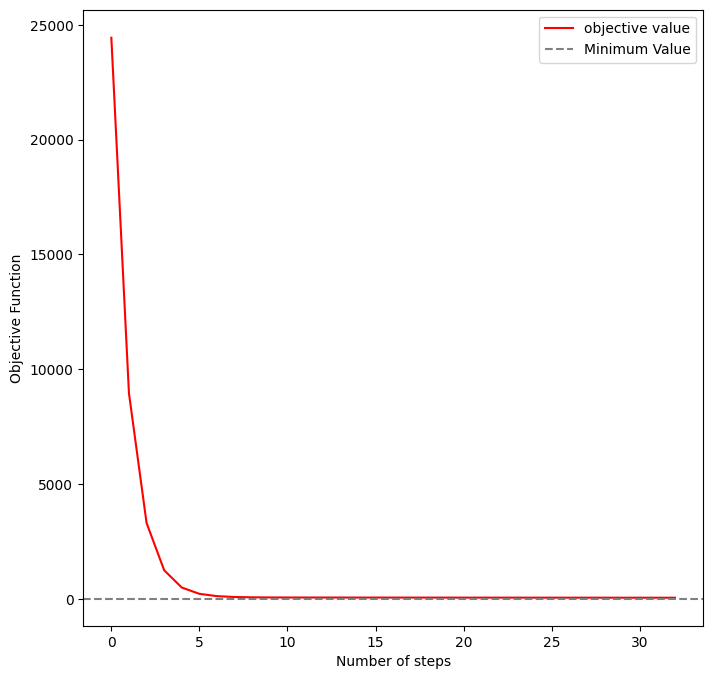

In [19]:
# Draw the objective function's value changes with the steps

Plotting_Scale = 30
actual_coordinates = int(max_iters / Plotting_Scale)

plt.figure(figsize=(8, 8))

plt.xlabel('Number of steps')

plt.ylabel('Objective Function')

plt.plot(range(actual_coordinates), objectives[:actual_coordinates],
         'r', label='objective value')

plt.axhline(y=y_best, color='grey', linestyle='--', label='Minimum Value')
plt.legend(loc='upper right')

plt.show()

In [21]:
N = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
max_iters = 1000

In [22]:
time_cost_with_n = []
memory_cost_with_n = []
objective_with_n = []

for n in N:
    init_x = create_init_x(n)
    wrapped_fun = partial(gradient_descent, init_x, max_iters, objective_function, damping_step_generator(lr=0.004), is_log=False)
    start_time = time.time()
    memory_cost, (objs, xs) = memory_usage(wrapped_fun, retval=True, interval=0.1)
    objective_with_n.append(objs[-1])
    end_time = time.time()
    time_cost = end_time - start_time
    time_cost_with_n.append(time_cost)
    memory_cost_with_n.append(max(memory_cost))
    print(f"n = {n}, obj={objs[-1]}, memory cost = {max(memory_cost)}, time cost = {time_cost}")

n = 100, obj=0.020387384711282455, memory cost = 118.07421875, time cost = 3.454474449157715
n = 200, obj=0.04077476942256491, memory cost = 114.375, time cost = 8.806442975997925


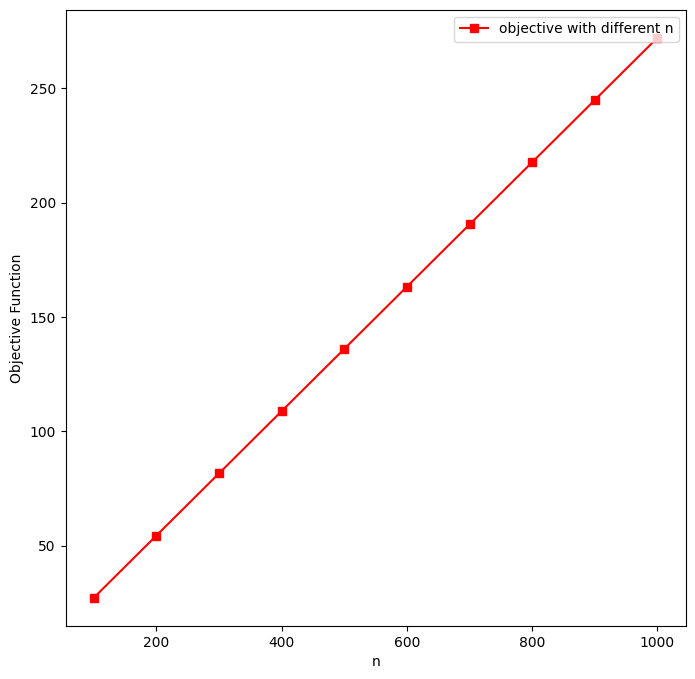

In [20]:
# Draw the objective function's value changes with the n
plt.figure(figsize=(8, 8))

plt.xlabel('n')
plt.ylabel('Objective Function')
plt.plot(N, objective_with_n, 'r', label='objective with different n', marker='s')
plt.legend(loc='upper right')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


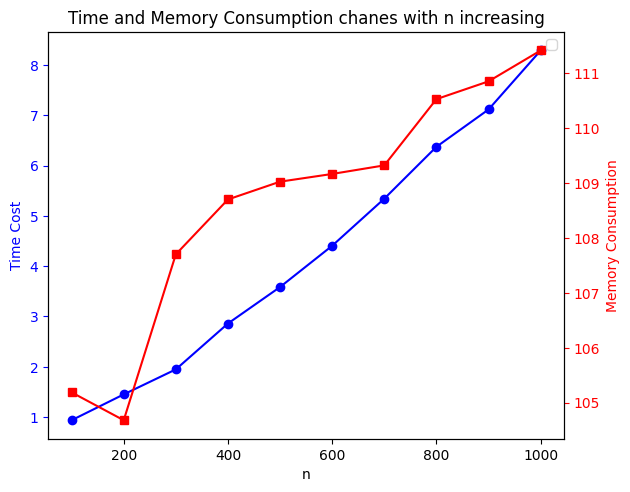

In [14]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots()

# 绘制时间消耗的折线图
ax1.plot(N, time_cost_with_n, marker='o', color='b')
ax1.set_xlabel('n')
ax1.set_ylabel('Time Cost', color='b')
ax1.tick_params('y', colors='b')

# 创建第二个纵坐标轴用于绘制空间消耗的折线图
ax2 = ax1.twinx()
ax2.plot(N, memory_cost_with_n, marker='s', color='r')
ax2.set_ylabel('Memory Consumption', color='r')
ax2.tick_params('y', colors='r')

# 添加图例
fig.tight_layout()
plt.legend()

# 添加标题
plt.title('Time and Memory Consumption chanes with n increasing')

# 显示图表
plt.show()